#  **Временные ряды: прогнозирование заказов такси**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Требование заказчика: значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# Цель проекта

**Главной целью** данного проекта стало предсказание количества заказов во время пиковой нагрузки для компании «Чётенькое такси», чтобы у них была возможность привлечь больше водителей, согласно предсказанной нагрузке. В ходе проекта будет подобрана лучшая модель с оптимальными гиперпараметрами, согласно поставленной задаче.

# Предоставленные заказчиком данные

Заказчик предоставил исходные данные, которые содержат в себе следующие признаки:
- datetime - дата и время
- num_orders - количество заказов (целевой признак)

## Подготовка данных

Для начала следует импортировать все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as ltb

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from time import time

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Следует изменить тип данных datetime с object на datetime

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Теперь следует исследовать на предмет дубликатов

In [6]:
data.duplicated().sum()

0

Пропусков и дубликатов не обнаружено.

Теперь следует ресемплировать по каждому часу, для того, чтобы в дальнейшим анализировать почасовую нагрузку заказов такси

In [7]:
data.sort_index(inplace=True)
data = data.resample('1H', on='datetime').sum()

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Следует более детально рассмотреть распределение количества заказов за час

In [9]:
data['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

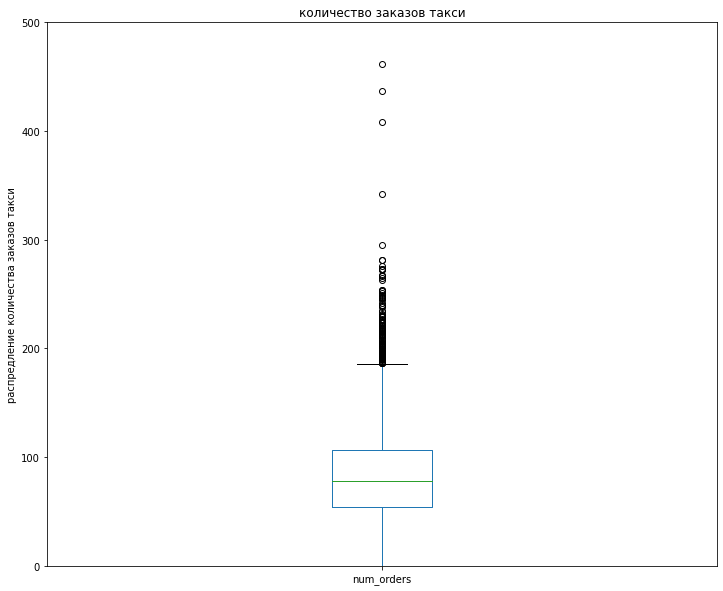

In [10]:
data['num_orders'].plot(kind='box', figsize=(12, 10))
plt.ylim (0, 500)

plt.ylabel('распредление количества заказов такси')
plt.title('количество заказов такси')
plt.show()

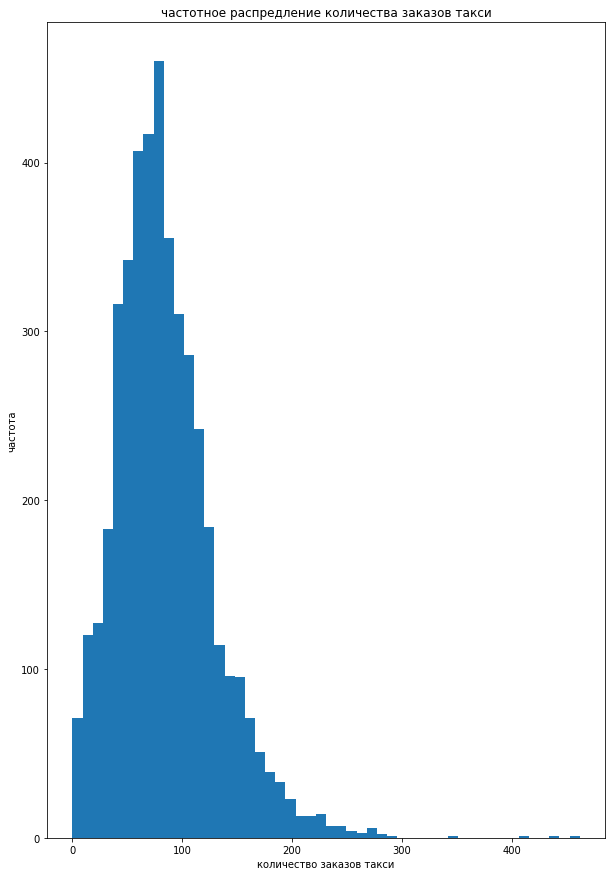

In [11]:
data['num_orders'].plot(kind = 'hist', figsize=(10, 15), bins = 50)
plt.xlabel('количество заказов такси')
plt.ylabel('частота')
plt.title('частотное распредление количества заказов такси')
plt.show()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод:** в исходных данных нет пропусков и дубликатов. В ходе подготовки данных было реализовано:  
- изменение типа данных на datetime
- ресемплирование по часу
- удаление выбросов

## Анализ

Следует проанализировать общий тренд за весь исследуемый период с марта по сентябрь, а также проанализировать тренд и сезонность в масштабе нескольких суток и недели

In [13]:
plt.rcParams ['figure.figsize'] = [20, 15]

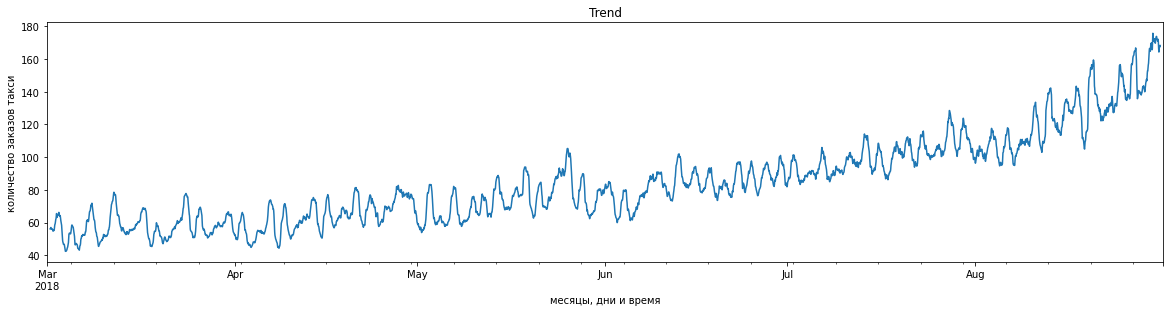

In [14]:
decomposition = seasonal_decompose(data)
plt.subplot(311)
decomposition.trend.plot(ax=plt.gca())
plt.xlabel('месяцы, дни и время')
plt.ylabel('количество заказов такси')
plt.title('Trend')
plt.show()

Для того, чтобы посмотреть сезонности в часовом масштабе, то это следует это сделать на примере нескольких суток, поскольку это соответсвует поставленной задаче

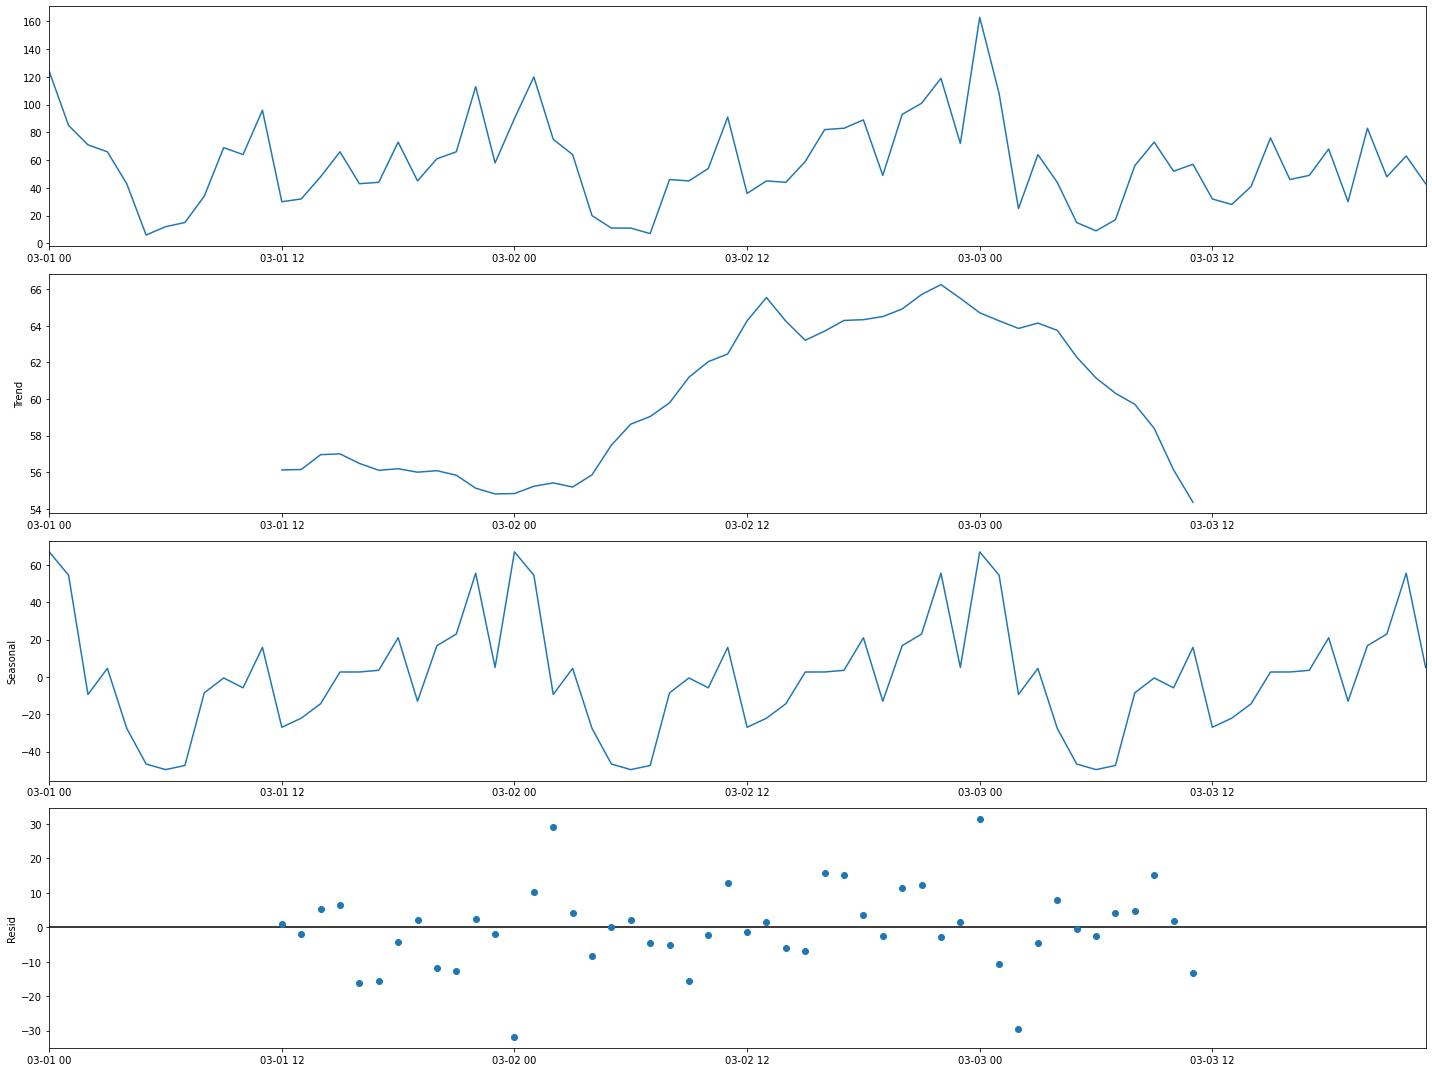

In [15]:
decomposition = seasonal_decompose(data['2018-03-01 00:00:00':'2018-03-03 23:00:00'])
decomposition.plot()
plt.show()

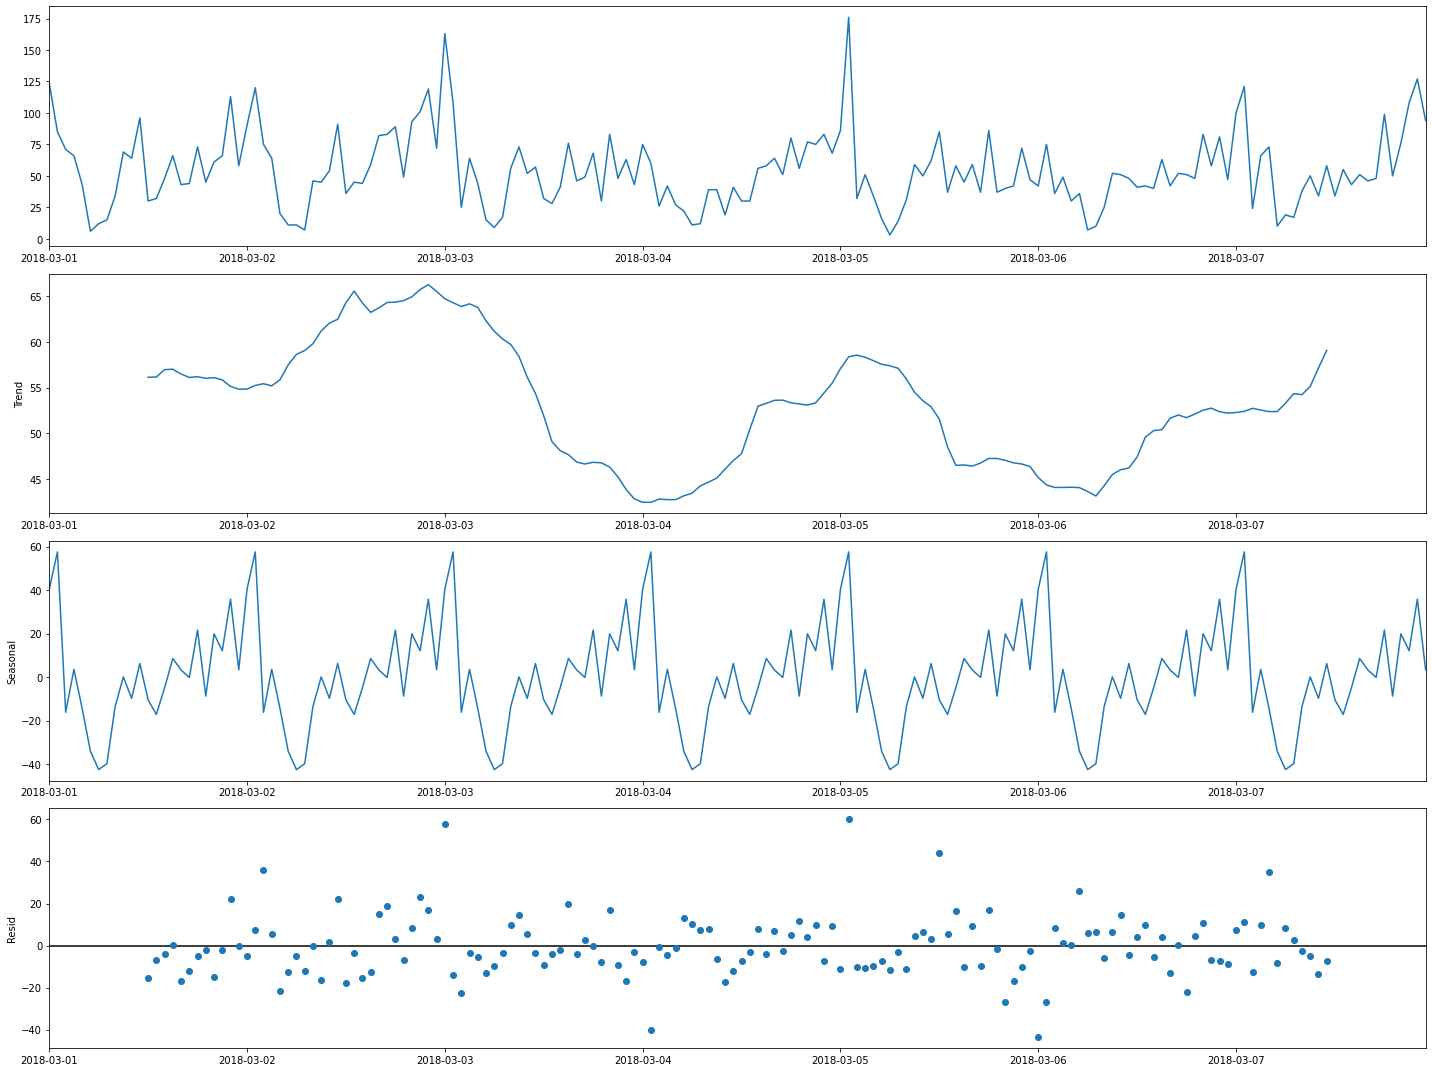

In [16]:
decomposition = seasonal_decompose(data['2018-03-01 00:00:00':'2018-03-07 23:00:00'])
fig = decomposition.plot()
plt.show()

Далее следует проанализировать стационарность временного ряда исходных данных, ресемлированных по часу.
Размер окна будет установлен 24, поскольку именно столько часов в сутках.

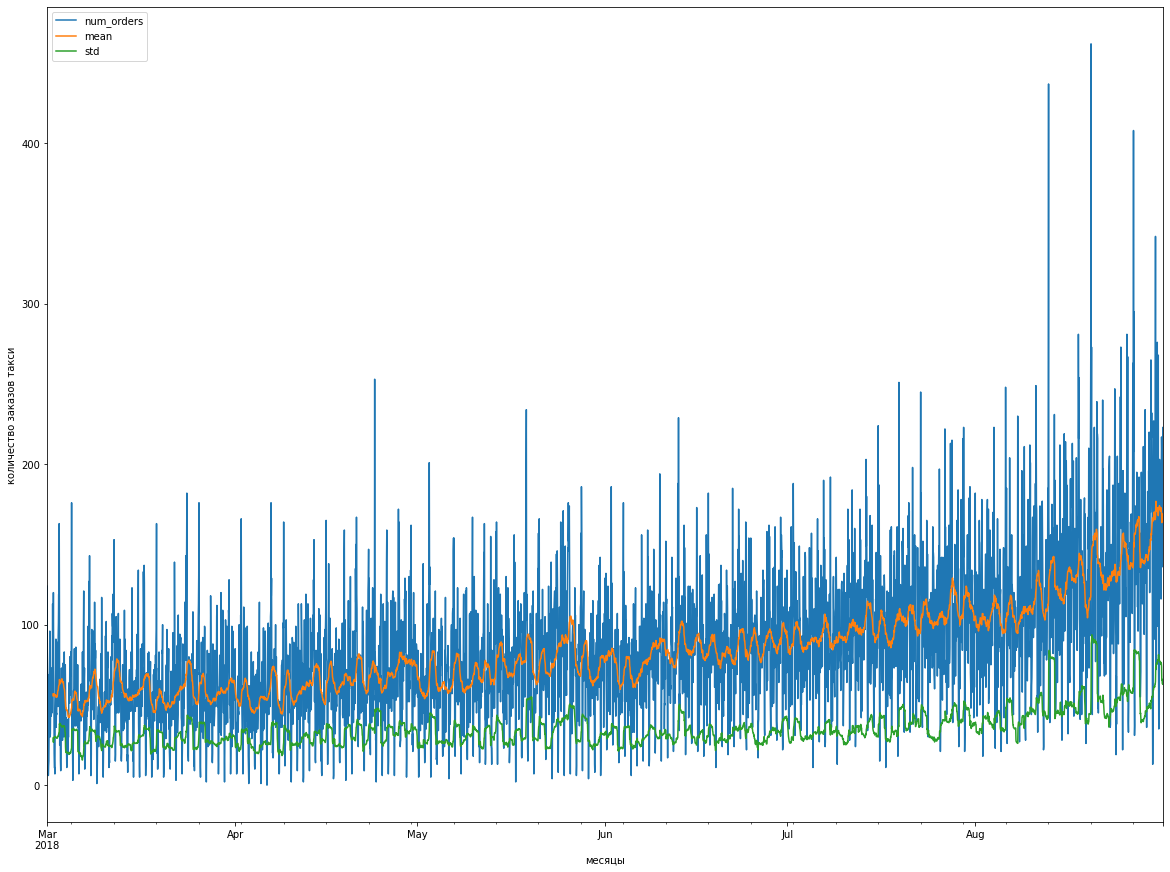

In [17]:
data['mean'] = data['num_orders'].shift().rolling(24).mean()
data['std'] = data['num_orders'].shift().rolling(24).std()
data.plot(xlabel='месяцы', ylabel = 'количество заказов такси')
plt.show()

Для проверки стационарности ряда так же стоит использовать обобщенный тест Дикки-Фуллера.

In [18]:
test = adfuller(data['num_orders'])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -3.0689242890279558
p-value:  0.028940051402612906
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
ряд стационарен


In [19]:
test = adfuller(data['num_orders'])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['1%']: 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -3.0689242890279558
p-value:  0.028940051402612906
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
ряд не стационарен


Для того, чтобы не было "утечки признаков" в будущем, стоит удалить столбцы со стандартным отклонением и средним значением целевого признака.

In [20]:
data = data.drop(columns=['std', 'mean'])

In [21]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:**   
В ходе анализа были проанализированы общий тренд, трехсуточный и недельный тренды и сезонность, а также стационарность ряда. Было обнаружено:  
- летом (с мая по сентябрь) наблюдается резкий рост спроса на такси возле аэропорта, что можно объяснить открытием сезона отпусков, а то, что в августе наблюдается пиковая нагрузка, может означать возвращение семейных пар перед школой домой или закрытие отпускного сезона;
- наблюдается почасовая сезонность спроса на услуги такси у аэропорта, поскольку пиковая нагрузка наблюдается в полночь, а также приблизительно в 10 вечера. Резкий спад спроса происходит в 3 часа ночи. Такое распредление повторяется изо дня в день, на основе анализа недельного периода.
- Для проверки стационарности временного ряда были визуализированы стандартное отклонение и среднее. Анализ показал, что среднее со временем увиличивается, а также нестабильно и стандартное отклонение, что могло означать не стационарность ряда. Для проверки гипотезы о не стационарности было проведено 2 теста Дикки-Фуллера. Науровне значимости 5% результат был отрицательный (ряд стационарен), однако, при уровне значимости 1% результат был обратным. Следовательно, ряд не является стационарным.

## Обучение

Перед началом обучения следует создать копию исходных данных.

In [22]:
def pep(df):
    df_pep = df.copy()
    return df_pep.dropna()

In [23]:
data_copy = pep(data)
data_copy.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Для начала следует написать функцию, которая добавит новые признаки для прогноза количества заказов. Необходимо создать календарные признаки, отстающие значения и скользящее среднее (следует сделать со сдвигом 1, поскольку так можно избежать утечки целевого признака).

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

Создадим признаки.

In [25]:
make_features(data_copy, 2, 24)

In [26]:
data_copy.head()

,num_orders,day,hour,weekday,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,1,4,3,66.0,71.0,NaN


Далее следует разделить данные на обучающую и тестовую выборку в соотношении 9:1

In [27]:
train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
train = train.dropna()

In [28]:
train_features = train.drop(['num_orders'], axis = 1)
train_target = train['num_orders']

test_features = test.drop(['num_orders'], axis = 1)
test_target = test['num_orders']

Далее следует подобрать модели обучения, релевантные поставленной задаче.  
Поскольку перед нами стоит задача регрессии (предсказание количества заказов текси), то следует рассмотреть регрессионные модели.

In [29]:
regressors = [
    GradientBoostingRegressor(random_state = 12345),
    RandomForestRegressor(random_state = 12345),
    DecisionTreeRegressor(random_state = 12345)
]

In [30]:
tss = TimeSeriesSplit(n_splits=5)

In [31]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(train_features, train_target)
    train_time = time() - start
    start = time()
    pred_train = model.predict(train_features)
    predict_time = time()-start
    scores = cross_val_score(estimator = model, cv=tss, X=train_features, y=train_target, scoring='neg_root_mean_squared_error')
    -np.average(scores)
    final_score = -(sum(scores) / len(scores))
    print(model)
    print("\tВремя обучения: %0.3fs" % train_time)
    print("\tВремя предсказания: %0.3fs" % predict_time)
    print('Средняя оценка качества модели:', final_score)
    print()

GradientBoostingRegressor(random_state=12345)
	Время обучения: 0.326s
	Время предсказания: 0.004s
Средняя оценка качества модели: 25.94705135903603

RandomForestRegressor(random_state=12345)
	Время обучения: 1.046s
	Время предсказания: 0.072s
Средняя оценка качества модели: 25.373576618452734

DecisionTreeRegressor(random_state=12345)
	Время обучения: 0.018s
	Время предсказания: 0.002s
Средняя оценка качества модели: 33.53791934536745



Таким образом, под требование заказчика, чтобы RMSE было меньше 48 подходит каждая из моделей. Следует пообрать оптимальные гиперпараметры для каждой.

**Модель GradientBoostingRegressor()**

In [32]:
parameters_1 = {'n_estimators' : (range(10, 100, 10)),
              'max_depth' : (range(1, 10))
             }

In [33]:
%%time
grid = GridSearchCV(GradientBoostingRegressor(),parameters_1, scoring='neg_root_mean_squared_error', cv = tss)

model = grid.fit(train_features, train_target)

print(model.best_params_,'\n')
print(-1*model.best_score_,'\n')

{'max_depth': 6, 'n_estimators': 50} 

25.929435937559447 

CPU times: user 58.3 s, sys: 213 ms, total: 58.5 s
Wall time: 58.6 s


**Модель RandomForestRegressor()**

In [34]:
parameters_2 = {'n_estimators' : (range(10, 100, 10)),
              'max_depth' : (range(1, 7))
             }

In [35]:
%%time
grid = GridSearchCV(RandomForestRegressor(),parameters_2, scoring='neg_root_mean_squared_error', cv = tss)

model = grid.fit(train_features, train_target)

print(model.best_params_,'\n')
print(-1*model.best_score_,'\n')

{'max_depth': 6, 'n_estimators': 20} 

27.326490658290805 

CPU times: user 30.7 s, sys: 184 ms, total: 30.9 s
Wall time: 30.9 s


**Модель DecisionTreeRegressor()**

In [36]:
parameters_3 = {'min_samples_split' : (range(2, 100)),
              'max_depth' : (range(1, 7))
             }

In [37]:
%%time
grid = GridSearchCV(DecisionTreeRegressor(),parameters_3, scoring='neg_root_mean_squared_error', cv = tss)

model = grid.fit(train_features, train_target)

print(model.best_params_,'\n')
print(-1*model.best_score_,'\n')

{'max_depth': 6, 'min_samples_split': 32} 

28.127057929567563 

CPU times: user 17 s, sys: 29 ms, total: 17 s
Wall time: 17.1 s


**Вывод:** таким образом, модель GradientBoostingRegressor() удовлетворяет требованию заказчика и показала лучшие показатели метрики качества, поэтому ее стоит протестировать на тестовой выборке

## Тестирование

In [40]:
%%time
model_1 = GradientBoostingRegressor(random_state = 12345, max_depth= 6, n_estimators=50)
model_1.fit(train_features, train_target)
predict_valid = model_1.predict(test_features)
print('RMSE:', sqrt(mean_squared_error(test_target, predict_valid)))

RMSE: 47.5215481147471
CPU times: user 300 ms, sys: 7.89 ms, total: 308 ms
Wall time: 307 ms


In [41]:
dummy_mean_0 = DummyRegressor(strategy = 'median').fit(train_features, train_target)
predict_dum_0 = dummy_mean_0.predict(test_features)

print('RMSE:', sqrt(mean_squared_error(test_target, predict_dum_0)))

RMSE: 87.15277582981295


**Общий вывод по проекту:**
- Была проанализирована стационарность временного ряда исходных данных;
- Были обнаружены пиковые часы нагрузки на услуги такси возле аэропорта;
- Поскольку задачей проекта является предсказание стоимости, то для этой задачи были обучены регрессионные модели GradientBoostingRegressor(), RandomForestRegressor(), DecisionTreeRegressor();
- Каждая из этих моделей удовлетворяла условиям заказчика о допустимом пороге RMSE, однако лучшей оказалась модель GradientBoostingRegressor() и именно она была протестирована на тестовой выборке; 
- Модель GradientBoostingRegressor() на тестовой выборке так же удовлетворяет требованиям заказчика, а именно RMSE = 47.5